In [1]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [45]:
# Parameters
dp_min = 0.5e-9                          # [m]
dp_max = 1000e-9                         # [m]
vp_min = np.pi * (dp_min)**3  /6          # [m^3] Start-Volumen
vp_max = np.pi * (dp_max)**3  /6         # [m^3] End-Volumen
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2) # Schrittweite
Q = 0.5 # Volumenstrom
B = 1 # Reaktorvolumen 
B = 2000
tau = B/Q # Verweilzeit

# Initial particle size
dp_0 = 0.5e-9
vp_0 = np.pi * (dp_0)**3  /6
N_0 = 1e17 #start_Zahl
A = 1e-1 # für q(v)

# Initialization for vspan
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)
vp = np.zeros((vp_num))
for i in range(vp_num): 
    vp[i] = vp_min * 2**i 

# Particle diameter span:
dp = ( 6 * vp/ np.pi)**(1/3.0)

# Analytic solution
# functions
def fun_q(v): 
    return A * v **(1/3)

def an_n(v): # analytic solution
    return (1/(A * v**(1/3.0))) * np.exp(
            (3/2.0) * (vp_0**(2/3.0) - v**(2/3.0))/(A * tau)
            ) * (N_0 / tau)

# Function to compute the number average particle distribution
def dp_avg(n, dp):
    """
    For a given particle distrubtion, return the number average particle distribution
    
    Params
    -----
    n : vector or array, particle number distribution
    dp : vector or array, particle diameter matching distribution `n``
    
    Returns
    -------
    dp, scalar, number average particle diameter
    """
    return np.sum(n * dp) / np.sum(n)




dp_avg = 3.508450755150071e-09 at B = 2000 m^3, tau = 4000.0 s


<IPython.core.display.Javascript object>


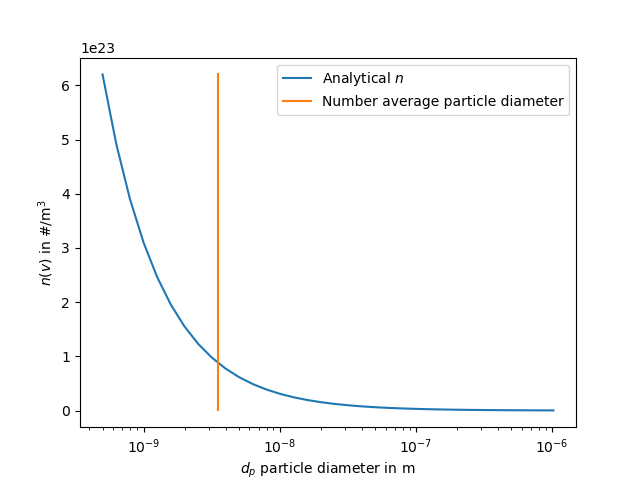

In [46]:
# Example, compute analytical solution:
n = an_n(vp)
# Next compute the number average particle diameter from the results:
dp_av = dp_avg(n, dp)
# In the next cell we plot the results
%matplotlib notebook
#tau
vp = np.zeros((vp_num))
for i in range(vp_num): 
    vp[i] = vp_min * 2**i 

# Compute number average particle diameter
dp_av = dp_avg(n, dp)
print(f'dp_avg = {dp_av} at B = {B} m^3, tau = {tau} s')
plt.semilogx(dp, n, label=r'Analytical $n$')
plt.semilogx([dp_av, dp_av], [np.min(an_n(vp)), np.max(an_n(vp))], label='Number average particle diameter')

plt.ylabel(r'$n(v)$ in #/m$^3$')
plt.xlabel(r'$d_p$ particle diameter in m')
plt.legend()


dp_av = 3.48509953252765e-09


<IPython.core.display.Javascript object>


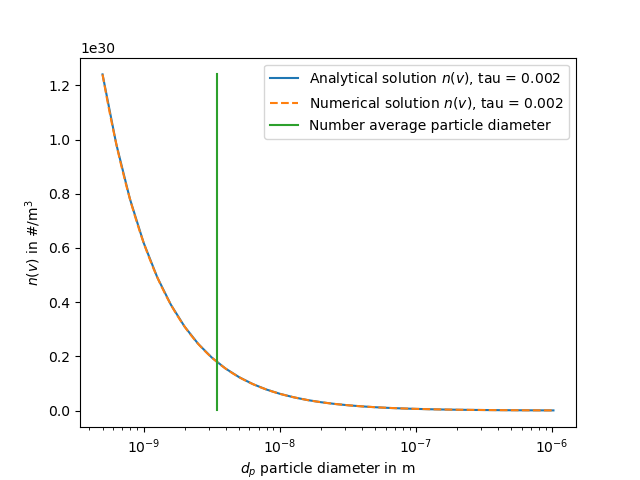

In [54]:
Q = 0.5 # Volumenstrom
B = 1e-3
tau = B/Q # Verweilzeit

def an_n(v): # analytic solution
    return (1/(A * v**(1/3.0))) * np.exp(
            (3/2.0) * (vp_0**(2/3.0) - v**(2/3.0))/(A * tau)
            ) * (N_0 / tau)


# dy / dt = f(t, y)
# d(nq) / dv = f(v, nq) = n_0/tau - n/tau
#def dnqdv(v, nq):
def dnqdv(v, nq):
    n = nq[0]/q
    if v > vp_min:
        dnqdv =  - n/tau
    else:
        dnqdv = N_0/tau - n/tau
    return dnqdv

# Initial value:
q = A * vp_min **(1/3.0)
y0 =  [N_0 / tau]
#y0 = y0[0]
# Solver options
options = {'rtol': 1e-12,
           'atol': 1e-12}

# Initialise data containers.
res_nq_list = []  # nq variable to be integrated
res_v_list = []  # v indepedent variable
vpn = vp.copy()  # Volume span
rv = 0.0
vp_min_n = vp_min
while rv < (vp_max * 0.99):
    # Solve the ivp:
    vpn = [vpn[0], vpn[1]]
    res = scipy.integrate.solve_ivp(dnqdv, vpn, y0, method='LSODA', **options)

    # Process results and save data:
    res_nq = res.y[0]
    res_v = res.t
    res_nq_list.extend(list(res_nq))
    res_v_list.extend(list(res_v))
    vp_min_n = res_v[-1]
    
    # Recompute particle bins
    vpn = vp.copy() 
    for i in range(vp_num): 
        vpn[i] = vp_min_n * 2**i 
    
    # Update the outer loop
    y0 = [res_nq[-1]]
    rv = res_v[-1]

# Recompute the particle values
res_nq = np.array(res_nq_list)
res_v = np.array(res_v_list)
q_sol = A * res_v **(1/3.0)
res_n = res_nq / q_sol
res_dp = ( 6 * res_v/ np.pi)**(1/3.0)
dp_av = dp_avg(res_n, res_dp)
print(f'dp_av = {dp_av}')

#NOTE: These are the results, you can rerun this cell to test if your code
#      matches the analytical solution:

%matplotlib notebook
#plt.semilogx(vp, an_nq(vp), label='Analytical nq')
plt.semilogx(dp, an_n(vp), label=f'Analytical solution $n(v)$, tau = {tau}')
plt.semilogx(res_dp, res_n, '--', label=f'Numerical solution $n(v)$, tau = {tau}')
plt.semilogx([dp_av, dp_av], [np.min(an_n(vp)), np.max(an_n(vp))], label='Number average particle diameter')
plt.ylabel(r'$n(v)$ in #/m$^3$')
plt.xlabel(r'$d_p$ particle diameter in m')
plt.legend()

### If you get this error please contact me!:

In [50]:
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Input In [35], in <cell line: 41>()
     40 vp_min_n = vp_min
     41 while rv < (vp_max * 0.99):
     42     # Solve the ivp:
---> 43     res = scipy.integrate.solve_ivp(dnqdv, vpn, y0, method='LSODA', **options)
     45     # Process results and save data:
     46     res_nq = res.y[0]

File /usr/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:512, in solve_ivp(fun, t_span, y0, method, t_eval, dense_output, events, vectorized, args, **options)
    507 if method not in METHODS and not (
    508         inspect.isclass(method) and issubclass(method, OdeSolver)):
    509     raise ValueError("`method` must be one of {} or OdeSolver class."
    510                      .format(METHODS))
--> 512 t0, tf = map(float, t_span)
    514 if args is not None:
    515     # Wrap the user's fun (and jac, if given) in lambdas to hide the
    516     # additional parameters.  Pass in the original fun as a keyword
    517     # argument to keep it in the scope of the lambda.
    518     fun = lambda t, x, fun=fun: fun(t, x, *args)

ValueError: too many values to unpack (expected 2)

SyntaxError: invalid syntax (863982196.py, line 1)